In [6]:
import tools
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, filtfilt, butter

import sys
import os
sys.path.insert(1, os.path.join("./tools/"))
from helpers import *

F0 = 60.0  # Frequency to be removed from signal (Hz)
Q = 30.0  # Quality factor



KeyError: 'helpers'

In [ ]:
def _bipolar_reference(data_arg):
    (n_time_samples, n_channels) = data_arg.shape
    # separate contact names
    leads = []
    contacts = []
    for i in data_arg.columns:
        if i in ['C3', 'C4', 'ECG1', 'ECG2']:
            n_channels = n_channels - 1
            continue

        M = re.match(r"(\D+)(\d+)", i)
        if M is None:
            n_channels = n_channels - 1
            continue
        leads.append(M.group(1).replace("EEG", "").strip())
        contacts.append(int(M.group(2)))

    leads_contacts = [f"{i}{j:02d}" for i, j in zip(leads, contacts)]
    col_names = []
    data_entries = []
    # find montage channel before
    for index in range(n_channels - 1):
        lead = leads[index]
        contact = contacts[index]

        next_lead_contact = f"{lead}{(contact + 1):02d}"

        try:
            next_index = leads_contacts.index(next_lead_contact)
        except ValueError:
            continue

        col_names.append(f"{leads_contacts[index]}-{leads_contacts[next_index]}")
        data_entries.append(data_arg.iloc[:, index] - data_arg.iloc[:, next_index])
    
    data_entries = np.array(data_entries).T
    bipolar_data = pd.DataFrame(data_entries, columns=col_names, index=data_arg.index)

    return bipolar_data


In [ ]:
# username = 'pattnaik'
# pwd_bin_file = '/mnt/local/gdrive/public/USERS/pattnaik/pre-ictal-similarity/code/pat_ieeglogin.bin'

username = 'igvilla'
pwd_bin_file = '/gdrive/public/USERS/igvilla/igv_ieeglogin.bin'

###

# practice of a random new time:
# start_time_sec = 315961
# end_time_sec = 315961 + 60 

# practice of a random new time:
# iEEG_filename = 'HUP231_phaseII'
# start_time_usec = start_time_sec * 1e6
# end_time_usec = end_time_sec * 1e6

# practice of a random new time:
# iEEG_filename = 'HUP231_phaseII'
# start_time_usec = start_time_sec * 1e6
# end_time_usec = end_time_sec * 1e6

### 

# LB3_001_phaseII, seizure 1:
start_time_sec = 262720.23 - 60 # showing starting 1 minute before the seizure
end_time_sec = 262720.23 + 176.600000000034

# LB3_001_phaseII, seizure 1:
iEEG_filename = 'LB3_004'
start_time_usec = start_time_sec * 1e6
end_time_usec = end_time_sec * 1e6




In [ ]:
data, fs = tools.get_iEEG_data(username, pwd_bin_file, iEEG_filename, start_time_usec, end_time_usec, select_electrodes=np.arange(25))



In [ ]:
start_time_usec, end_time_usec

(262660229999.99997, 262896830000.00003)

In [ ]:
262896830000.00003 - 262660229999.99997

236600000.00006104

In [ ]:
# extract dims
(n_samples, n_channels) = data.shape

# set time array
t_sec = np.linspace(start_time_sec, end_time_sec, n_samples)

# remove 60Hz noise
b, a = iirnotch(F0, Q, fs)
signal_filt = filtfilt(b, a, data, axis=0)

# bandpass between 1 and 120Hz
bandpass_b, bandpass_a = butter(3, [1, 120], btype='bandpass', fs=fs)
signal_filt = filtfilt(bandpass_b, bandpass_a, signal_filt, axis=0)

# format resulting data into pandas DataFrame
signal_filt = pd.DataFrame(signal_filt, columns=data.columns)
signal_filt.index = pd.to_timedelta(t_sec, unit="S")

signal_ref = _bipolar_reference(signal_filt)

In [ ]:
np.size(signal_ref)

545130

In [ ]:
signal_ref

,A01-A02,EKG01-EKG02,F03-F04,F07-F08,F08-F09,F09-F10,Fp01-Fp02,O01-O02,P03-P04
3 days 00:57:40.230000,1.472254,3.057266,4.876530,5.932883,1.226775,0.591392,-0.934213,-23.030836,13.750383
3 days 00:57:40.233906289,-7.211279,43.525584,-34.239226,-99.051420,10.532062,27.995590,-53.932762,-179.380667,26.162461
3 days 00:57:40.237812577,-10.676860,-25.793393,-53.783085,37.436145,-32.335518,16.702546,4.581890,19.540178,-8.632398
3 days 00:57:40.241718866,-1.337779,33.475512,3.040416,-6.305548,14.082475,-6.463693,54.706653,-18.077133,-3.695529
3 days 00:57:40.245625155,3.280007,7.261745,-17.603719,20.646682,-27.310828,-8.158371,22.169205,-74.696875,36.148630
...,...,...,...,...,...,...,...,...,...
3 days 01:01:36.814374845,-23.368202,-98.216819,-4.156618,-11.171419,-89.604198,92.910954,7.483595,22.726139,8.016144
3 days 01:01:36.818281134,-20.144524,-91.219199,-8.067465,-7.921929,-81.408959,84.077168,6.570659,21.616795,9.027173
3 days 01:01:36.822187423,-19.294715,-99.418554,-8.493694,-9.084140,-84.112214,87.177002,-0.790791,19.436396,9.438116
3 days 01:01:36.826093711,-17.160612,-91.215926,-10.047964,-12.056941,-74.035759,77.597973,-8.434008,14.226665,8.482589


In [ ]:
signal_ref.to_hdf(f"../data/eeg_pt-{iEEG_filename}_start-{start_time_sec}_end-{end_time_sec}.h5", key='ieeg')

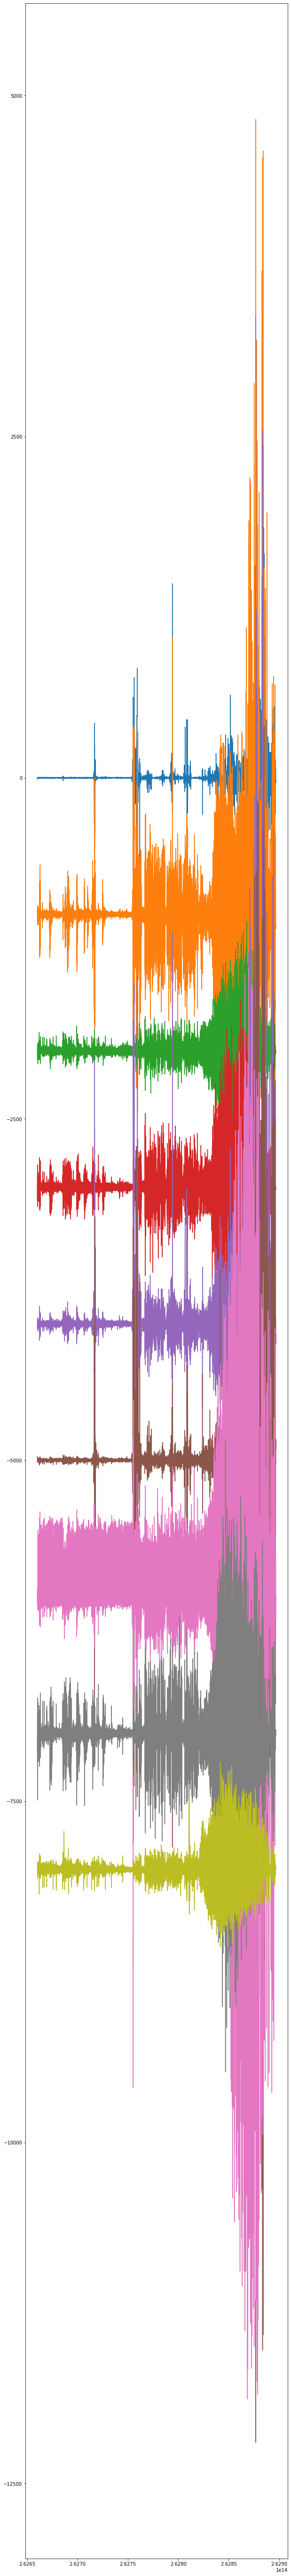

In [ ]:
# changed from 34 to 9
plt.figure(figsize=(10, 100)); plt.plot(signal_ref.iloc[:, 0:9] + np.arange(9)*-1000)